# Background

- Uses two datafiles starting 2019-12-04 and 2019-12-13
- These are for the temperature tests of Hall probes
- Second file stopped 2019-01-08

# Code

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from dateutil import parser
from datetime import datetime
from sys import getsizeof
import re

import operator
from scipy import stats
import scipy.optimize as optimization
import lmfit as lm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['axes.axisbelow'] = True

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
init_notebook_mode(True)

import seaborn as sns

from wand.image import Image as WImage

from hallprobecalib import hpc_ext_path
from hallprobecalib.hpcplots import scatter2d,scatter3d,histo,py_profile

In [5]:
make_plots = False#True # False

In [6]:
plotdir = hpc_ext_path+'plots/hall_probe_stability/2019-12-04/'

In [7]:
pkl_dir = hpc_ext_path+"datafiles/hall_probe_stability/"
pkl_file_slow = "hall_stability.run06.raw.slow.pkl"
#pkl_file_fast = "hall_stability.run06.raw.fast.pkl"
#pkl_file_fast_sparse = "hall_stability.run06.sparse.fast.pkl"

In [8]:
df = pd.read_pickle(pkl_dir+pkl_file_slow)

In [8]:
#df_fast = pd.read_pickle(pkl_dir+pkl_file_fast)
#df_fast_sparse = pd.read_pickle(pkl_dir+pkl_file_fast_sparse)

In [9]:
#df_fast['seconds_delta'].iloc[60:75]

In [10]:
df['seconds_delta'].head(10)

Datetime
2019-12-04 14:38:18      0.0
2019-12-04 14:39:08     50.0
2019-12-04 14:39:58    100.0
2019-12-04 14:40:48    150.0
2019-12-04 14:41:38    200.0
2019-12-04 14:42:28    250.0
2019-12-04 14:43:18    300.0
2019-12-04 14:44:09    351.0
2019-12-04 14:44:58    400.0
2019-12-04 14:45:48    450.0
Name: seconds_delta, dtype: float64

In [9]:
def pplot(fig):
    pio.write_image(fig, 'temp.pdf')
    img = WImage(filename='temp.pdf')
    return img

## Cleaning

In [12]:
directory = "/home/ckampa/Dropbox/LogFiles/"#hpc_ext_path+'datafiles/magnet_stability/nmr/'
filename_slow = '2019-12-04 143741slow.txt'#'2019-12-03 162209slow.txt' ## NO NMR IN FIRST FILE
filename_slow_2 = '2019-12-13 111933slow.txt'

In [13]:
df = pd.read_csv(directory+filename_slow)
df.columns = df.columns.str.lstrip(" ")
df.drop("", axis=1, inplace=True)
dates = [parser.parse(row.Time) for row in df.itertuples()]# if isdatetime(row.Time.values[0])]
df["Datetime"] = pd.to_datetime(dates)#.astype("str")
df = df.set_index("Datetime")
## THOMAS WORKING ON WATER CHILLER INSTALLATION
## MAGNET OFF AND TEMPS GET WEIRD
df = df[:"2019-12-12 14:26:00"]

In [14]:
df2 = pd.read_csv(directory+filename_slow_2)
df2.columns = df2.columns.str.lstrip(" ")
df2.drop("", axis=1, inplace=True)
dates = [parser.parse(row.Time) for row in df2.itertuples()]# if isdatetime(row.Time.values[0])]
df2["Datetime"] = pd.to_datetime(dates)#.astype("str")
df2 = df2.set_index("Datetime")

In [15]:
df2

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,C50000000D5E473A_Cal_Z,DF0000000D5E803A_Cal_T,6A0000000D61333A_Cal_T,C50000000D5E473A_Cal_T,Zaber_Meas_MicroStep_X,Zaber_Meas_Encoder_X,Zaber_Meas_MicroStep_Y,Zaber_Meas_Encoder_Y,Zaber_Meas_MicroStep_Z,Zaber_Meas_Encoder_Z
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-12-13 11:20:10,12/13/2019 11:20:10 AM,256.071510,30.961017,33.549297,31.119984,7.549104,10.463340,12.334523,14.516138,20.578840,...,-0.004689,16.668,17.473,16.992,249952.34375,639878.0,184468.359375,472239.0,750100.0,1920256.0
2019-12-13 11:21:00,12/13/2019 11:21:00 AM,256.071397,30.958833,33.572384,31.076975,7.546639,10.444542,12.321710,14.500689,20.559849,...,-0.004700,16.602,17.491,16.973,249952.34375,639878.0,184468.359375,472239.0,750100.0,1920256.0
2019-12-13 11:21:50,12/13/2019 11:21:50 AM,256.071453,30.956683,33.515110,31.088324,7.504282,10.426469,12.294535,14.481849,20.536831,...,-0.004701,16.608,17.493,16.972,249952.34375,639878.0,184468.359375,472239.0,750100.0,1920256.0
2019-12-13 11:22:40,12/13/2019 11:22:40 AM,256.071453,30.954517,33.549179,31.075892,7.492641,10.419066,12.282623,14.467204,20.528875,...,-0.004674,16.630,17.486,16.981,249952.34375,639878.0,184468.359375,472239.0,750100.0,1920256.0
2019-12-13 11:23:30,12/13/2019 11:23:30 AM,256.071453,30.952550,33.496910,31.055244,7.472020,10.411821,12.273101,14.450148,20.508961,...,-0.004699,16.599,17.472,16.948,249952.34375,639878.0,184468.359375,472239.0,750100.0,1920256.0
2019-12-13 11:24:20,12/13/2019 11:24:20 AM,256.071397,30.950333,33.482323,31.040310,7.478202,10.385602,12.247592,14.435091,20.490322,...,-0.004709,16.604,17.472,16.963,249952.34375,639878.0,184468.359375,472239.0,750100.0,1920256.0
2019-12-13 11:25:10,12/13/2019 11:25:10 AM,256.071567,30.948300,33.464439,31.019918,7.466934,10.388030,12.240971,14.422956,20.474533,...,-0.004710,16.575,17.453,16.944,249952.34375,639878.0,184468.359375,472239.0,750100.0,1920256.0
2019-12-13 11:26:00,12/13/2019 11:26:00 AM,256.071623,30.946300,33.429817,31.011446,7.465701,10.371524,12.243831,14.411193,20.455461,...,-0.004717,16.574,17.448,16.927,249952.34375,639878.0,184468.359375,472239.0,750100.0,1920256.0
2019-12-13 11:26:50,12/13/2019 11:26:50 AM,256.071567,30.944400,33.453201,30.982565,7.443418,10.356134,12.226747,14.400058,20.440203,...,-0.004687,16.557,17.442,16.917,249952.34375,639878.0,184468.359375,472239.0,750100.0,1920256.0


In [16]:
df = pd.concat([df,df2], axis=0)

In [17]:
## PLOT ALL
#for col in df.columns:
#    fig = scatter2d(df.index, df[col], show_plot=False)
#    fname = f"{plotdir}time/all/{col}_vs_time"
#    pio.write_image(fig, fname+".pdf")
#    pio.write_image(fig, fname+".png")

In [18]:
probes = np.array([])
for col in df.columns:
    #print(df_fast[col].dtype)
    if ("Raw" in col) or ("Cal" in col):#type(df[col].iloc[0]) is np.float64:
        #print(f"{col}")#": mean: {df[col].mean()}")
        probes = np.append(probes, col[:16])
probes = list(np.unique(probes))
#print(probes)

In [19]:
probe = probes[2]

In [20]:
probe

'DF0000000D5E803A'

In [21]:
#for col in df.columns:
    #print(df_fast[col].dtype)
#    if type(df[col].iloc[0]) is np.float64:
#        print(f"{col}: mean: {df[col].mean()}")

- Looks like maybe probe "DF0000000D5E803A" is in the field
- NMR [T] = 0?

### Slow Control Data Cleaning

In [22]:
for probe in probes:
    for t in ["Cal", "Raw"]:
        df[f"{probe}_{t}_Bmag"] = (df[f"{probe}_{t}_X"]**2+df[f"{probe}_{t}_Y"]**2+df[f"{probe}_{t}_Z"]**2)**(1/2)
        df[f"{probe}_{t}_Res"] = df[f"{probe}_{t}_Bmag"] - df['NMR [T]']
        df[f"{probe}_{t}_Res_Rel"] = (df[f"{probe}_{t}_Bmag"] - df['NMR [T]']) / df['NMR [T]']

In [23]:
for B in ["X", "Y", "Z"]:
    for probe in probes:
        for t in ["Cal", "Raw"]:
            #df[f"{probe}_{t}_Bmag"] = (df[f"{probe}_{t}_X"]**2+df[f"{probe}_{t}_Y"]**2+df[f"{probe}_{t}_Z"]**2)**(1/2)
            df[f"{probe}_{t}_{B}_Res"] = df[f"{probe}_{t}_{B}"] - df['NMR [T]']
            df[f"{probe}_{t}_{B}_Res_Rel"] = (df[f"{probe}_{t}_{B}"] - df['NMR [T]']) / df['NMR [T]']

In [24]:
df["seconds_delta"] = (df.index - df.index[0]).total_seconds()
df["hours_delta"] = (df.index - df.index[0]).total_seconds()/60**2
df["days_delta"] = (df.index - df.index[0]).total_seconds()/(24*60**2)

In [25]:
for t in ["Cal", "Raw"]:
    for probe in probes:
        df[f"{probe}_{t}_Transverse"] = (df[f"{probe}_Cal_X"]**2+df[f"{probe}_Cal_Y"]**2)**(1/2)
        df[f"{probe}_{t}_Theta"] = np.arccos(df[f"{probe}_Cal_Z"]/df[f"{probe}_Cal_Bmag"])
        df[f"{probe}_{t}_Phi"] = np.arccos(df[f"{probe}_Cal_X"]/df[f"{probe}_Cal_Transverse"])

In [26]:
# raw
for probe in probes:
    df[f"{probe}_Raw_Bmag"] = (df[f"{probe}_Raw_X"]**2+df[f"{probe}_Raw_Y"]**2+df[f"{probe}_Raw_Z"]**2)**(1/2)

for probe in probes:
    df[f"{probe}_Raw_Transverse"] = (df[f"{probe}_Raw_X"]**2+df[f"{probe}_Raw_Y"]**2)**(1/2)
    df[f"{probe}_Raw_Theta"] = np.arccos(df[f"{probe}_Raw_Z"]/df[f"{probe}_Raw_Bmag"])
    df[f"{probe}_Raw_Phi"] = np.arccos(df[f"{probe}_Raw_X"]/df[f"{probe}_Raw_Transverse"])

In [28]:
if make_plots:
    ## TIME PLOTS
    for col in df.columns:
        fig = scatter2d(df.index, df[col], markers=False, lines=True, show_plot=False) 
        pio.write_image(fig, plotdir+f"time/all/{col}_vs_time.pdf")
        pio.write_image(fig, plotdir+f"time/all/{col}_vs_time.png")
    
    ## PLOT HISTOS
    for probe in probes:
        for t in ["Cal", "Raw"]:
            fig = histo(df[f"{probe}_{t}_Bmag"], bins=50, show_plot=False)
            pio.write_image(fig, plotdir+f"histo/{probe}_{t}_Bmag.pdf")
            pio.write_image(fig, plotdir+f"histo/{probe}_{t}_Bmag.png")

    ## RES HISTOS
    for t in ["Cal", "Raw"]:
        for probe in probes:
            for B in ["X","Y","Z"]:
                fig = histo(df[f"{probe}_{t}_{B}_Res"], bins=50, show_plot=False)
                pio.write_image(fig, plotdir+f"histo/residuals/component/{probe}_{t}_{B}_Res.pdf")
                pio.write_image(fig, plotdir+f"histo/residuals/component/{probe}_{t}_{B}_Res.png")

    ## REL_RES HISTOS
    for t in ["Cal", "Raw"]:
        for probe in probes:
            for B in ["X","Y","Z"]:
                fig = histo(df[f"{probe}_{t}_{B}_Res_Rel"], bins=50, show_plot=False)
                pio.write_image(fig, plotdir+f"histo/relative_residuals/component/{probe}_{t}_{B}_Res_Rel.pdf")
                pio.write_image(fig, plotdir+f"histo/relative_residuals/component/{probe}_{t}_{B}_Res_Rel.png")

    ## BMAG RES HISTOS
    for res in ["Res", "Res_Rel"]:
        if res == "Res":
            p = "residuals"
        else:
            p = "relative_residuals"
        for t in ["Cal", "Raw"]:
            for probe in probes:
                #for B in ["X","Y","Z"]:
                fig = histo(df[f"{probe}_{t}_{res}"], bins=50, show_plot=False)
                pio.write_image(fig, plotdir+f"histo/{p}/{probe}_{t}_Bmag_{res}.pdf")
                pio.write_image(fig, plotdir+f"histo/{p}/{probe}_{t}_Bmag_{res}.png")

    ## PLOT HISTO ANGLE
    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = histo(df[f"{probe}_Cal_{angle}"], bins=30, show_plot=False)
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Cal_{angle}.pdf")
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Cal_{angle}.png")

    ## PLOT ANGLE
    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = scatter2d(df.index, df[f"{probe}_Cal_{angle}"], show_plot=False)
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Cal_{angle}.pdf")
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Cal_{angle}.png")

    ## PLOT ANGLES RAW
    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = histo(df[f"{probe}_Raw_{angle}"], bins=30, show_plot=False)
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Raw_{angle}.pdf")
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Raw_{angle}.png")

    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = scatter2d(df.index, df[f"{probe}_Raw_{angle}"], show_plot=False)
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Raw_{angle}.pdf")
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Raw_{angle}.png")

/home/ckampa/anaconda3/envs/Mu2E/lib/python3.7/site-packages/numpy/lib/function_base.py:3768: RuntimeWarning:

invalid value encountered in multiply



In [30]:
df.to_pickle(pkl_dir+pkl_file_slow)

In [31]:
getsizeof(df) / 1000/1000

75.11953299999999

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58795 entries, 2019-12-04 14:38:18 to 2020-01-08 12:08:40
Columns: 150 entries, Time to DF0000000D5E803A_Raw_Phi
dtypes: float64(149), object(1)
memory usage: 67.7+ MB


## Plotting

### First Attempt

In [10]:
df.tail(1)

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,DF0000000D5E803A_Cal_Phi,6A0000000D61333A_Raw_Transverse,6A0000000D61333A_Raw_Theta,6A0000000D61333A_Raw_Phi,C50000000D5E473A_Raw_Transverse,C50000000D5E473A_Raw_Theta,C50000000D5E473A_Raw_Phi,DF0000000D5E803A_Raw_Transverse,DF0000000D5E803A_Raw_Theta,DF0000000D5E803A_Raw_Phi
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-08 12:08:40,1/8/2020 12:08:40 PM,256.0727,30.86205,32.74165,30.332678,7.005564,9.925889,11.6269,13.902221,16.686592,...,1.595403,140.003571,0.030308,1.563654,60728.119097,1.231013,1.365834,3.515507e+06,1.531121,1.108786


In [11]:
len(df)

58795

In [12]:
len(df) * 50 / 60 / 60 / 24

34.02488425925926

In [13]:
df = df[df["NMR [T]"] > 0.1]

In [16]:
fig = histo(df["NMR [T]"], bins=50, inline=False)

In [ ]:
#fig = scatter2d(df.index, df["NMR [T]"], show_plot=False);

In [ ]:
#pplot(fig)

In [ ]:
#fig = scatter2d(df.index, df["NMR [T]"])

In [ ]:
#plot(fig)

In [65]:
# magnet off 12-13 to 12-16
df_ = df["12-13-2019 17:10:00":"12-16-2019 07:56:00"]

In [66]:
###### take out magnet off
df = pd.concat([df[:"12-13-2019 17:08:00"], df["12-16-2019 07:57:00":]])

In [37]:
fig = scatter2d(3*[df.index], [df[col+"_Cal_Bmag"] for col in probes], inline=False);

In [176]:
fig = scatter2d(2*[df.index], [df["NMR [T]"], df[f"{probe}_Cal_Bmag"]], show_plot=False);

In [177]:
plot(fig)

'temp-plot.html'

In [41]:
###### take out magnet off
#df = pd.concat([df[:"12-13-2019 17:10:00"], df["12-16-2019 07:56:00":]])

In [42]:
#fig = scatter2d(3*[df_.index], [df_[col+"_Cal_Bmag"] for col in probes], inline=False);

In [43]:
#fig = scatter2d(df.index, df["Chamber Wall CH13"])

In [44]:
fig = scatter2d(df.index, df[f"{probe}_Cal_Res_Rel"], show_plot=False);

In [45]:
plot(fig)

'temp-plot.html'

In [46]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Cal_Res_Rel"], df.days_delta, inline=False);

In [47]:
fig = scatter2d(df["Roof"], df[f"{probe}_Cal_Res_Rel"], df.days_delta, inline=False);

~ -5e-5 change in residual after changing temperature (+4 deg C).

In [48]:
fig = histo(df[f"{probe}_Cal_Res_Rel"], bins=75, show_plot=False);
plot(fig)
#fig = histo(df[f"{probe}_Cal_Res_Rel"], bins=50, yscale='log')

'temp-plot.html'

In [49]:
df["day"] = df.index.day

In [50]:
fig = px.histogram(df, x=f"{probe}_Cal_Res_Rel", color="day")

In [51]:
fig.update_layout(
    autosize=False,
    width=1800,
    height=800
    #margin=dict(l=20, r=20, t=20, b=20),
    #padding=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="LightSteelBlue",
);

In [52]:
#fig.show()

In [53]:
plot(fig)

'temp-plot.html'

In [54]:
# temps

In [55]:
temps_ch = [a for a in df.columns if ("CH" in a) and int(a[-2:])<21]# or "HVAC" in a]
temps_ch.append("Hall Element")
temps_ch.append("Floor")
temps_ch.append("Roof")
temps_ch.append("Yoke")
temps_ch.append("Yoke (center magnet)")

In [56]:
#temps_ch

In [67]:
### MAGNET OFF
fig = scatter2d([df_.index for c in temps_ch],[df_[c] for c in temps_ch],inline=True, show_plot=False);
fig.layout.title = "Temp vs. Datetime (magnet off)"
fig.layout.yaxis.title = "Temp [deg. C]";

#fig.show()
#plot(fig)

#fname = 'temps_scatter'
#fname = 'time/temps/temps_scatter_full'
#pio.write_image(fig, plotdir+fname+'.pdf')
#pio.write_image(fig, plotdir+fname+'.png')
#plot(fig, filename=plotdir+fname+'.html', auto_open=False)

probe = probes[2]

fig.add_trace(go.Scatter(x=df_.index, y=df_[f"{probe}_Cal_T"], mode="lines", name=f"{probe}_Cal_T"));

#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_full_magnet_off'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

plot(fig)

'temp-plot.html'

In [68]:
df_["Yoke"].max()

17.2656002

In [69]:
(df_["Yoke"].max() - df_["Yoke"].min()) / np.exp(1)

2.1621295255215482

In [70]:
df_["Yoke"].max()/np.exp(1)

6.351659353065544

In [71]:
### MAGNET OFF
ys = ["Yoke", "Yoke (center magnet)"]
fig = scatter2d([df_.index for c in ys],[df_[c] for c in ys],inline=True, show_plot=False);
fig.layout.title = "Temp vs. Datetime (magnet off)"
fig.layout.yaxis.title = "Temp [deg. C]";

y = df_["Yoke"].max() - (df_["Yoke"].max() - df_["Yoke"].min()) / np.exp(1)

xs = pd.to_datetime([df_.iloc[0]['Time'], df_.iloc[-1]['Time']]) #np.linspace(x_dat.min(), x_dat.max(), 100)
ys = [y, y]#result.eval(x=xs)
fig.add_trace(go.Scatter(
                    x=xs, y=ys,
                    mode='lines', name=f'1/e point',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=2,
                              dash='dash')));
    
fname = 'time/temps/yoke_temp_magnet_off'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

plot(fig)

'temp-plot.html'

In [72]:
def exp(t, y0, tau, C):
    return y0 * np.exp(- t / tau) + C

In [73]:
guess = np.array([5., 6, 11.4])

In [74]:
#df_["t"] = df_.seconds_delta - df_.seconds_delta.min()
df_["dt [hours]"] = df_.hours_delta - df_.hours_delta.min()

In [75]:
x_dat = df_["dt [hours]"]#["t"]
y_dat = df_["Yoke (center magnet)"]

In [76]:
params, cov = optimization.curve_fit(exp, x_dat, y_dat, guess)

In [77]:
# yoke (center magnet)
params, cov

(array([ 5.43184745,  3.31925669, 12.47172496]),
 array([[ 2.46686714e-06, -1.50655291e-06, -3.48425597e-10],
        [-1.50655291e-06,  2.09817468e-06, -1.01741129e-07],
        [-3.48425597e-10, -1.01741129e-07,  4.17109574e-08]]))

In [78]:
#ts = np.linspace(df_["t"].min(), df_["t"].max(), 1000)
ts = np.linspace(df_["dt [hours]"].min(), df_["dt [hours]"].max(), 2000)

In [79]:
ys = exp(ts, params[0], params[1], params[2])

In [80]:
ys.min()

12.471724996316706

In [81]:
ep = y_dat.max() - (y_dat.max()-y_dat.min()) / np.exp(1)

In [82]:
ep

15.764020423189548

In [83]:
e_deg_t = ts[np.isclose(ys, ep, atol=1e-2,)][0]#rtol=0.00000001)]
e_deg_y = ys[np.isclose(ys, ep, atol=1e-2,)][0]#rtol=0.00000001)]

In [84]:
e_deg_t

1.663751042187762

In [85]:
half_deg_t = ts[np.isclose(ys, ys.min()+0.5, atol=1e-3,)][0]#rtol=0.00000001)]
half_deg_y = ys[np.isclose(ys, ys.min()+0.5, atol=1e-3,)][0]#rtol=0.00000001)]

In [86]:
tenth_deg_t = ts[np.isclose(ys, ys.min()+0.1, atol=1e-3,)][0]#rtol=0.00000001)]
tenth_deg_y = ys[np.isclose(ys, ys.min()+0.1, atol=1e-3,)][0]#rtol=0.00000001)]

In [87]:
### MAGNET OFF
### FINAL PLOT
ys = ["Yoke", "Yoke (center magnet)"]
fig = scatter2d([df_["dt [hours]"] for c in ys],[df_[c] for c in ys],inline=True, show_plot=False);
fig.layout.title = "Temp vs. Datetime (magnet off)"
fig.layout.yaxis.title = "Temp [deg. C]";

x_e = params[1]
x_p5 = half_deg_t
x_p1 = tenth_deg_t
y0 = df_['Yoke'].min()#y_dat.min()
yf = y_dat.max()

xs1 = [x_e, x_e]
ys1 = [y0, yf]
xs2 = [x_p5, x_p5]
ys2 = [y0, yf]
xs3 = [x_p1, x_p1]
ys3 = [y0, yf]

#xs = pd.to_datetime([df_.iloc[0]['Time'], df_.iloc[-1]['Time']]) #np.linspace(x_dat.min(), x_dat.max(), 100)
#ys = [y, y]#result.eval(x=xs)
fig.add_trace(go.Scatter(
                    x=xs1, y=ys1,
                    mode='lines', name=f'1/e @ dt = {x_e:.2f} hours',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=2,
                              dash='dash')));

fig.add_trace(go.Scatter(
                    x=xs2, y=ys2,
                    mode='lines', name=f'0.5 deg from final<br>temp @ dt = {x_p5:.2f} hours',#"|V|/|B| = A * Temp. + B",
                    line=dict(color="deeppink",#'rgb(78, 42, 132)',#'deeppink',
                              width=2,
                              dash='dash')));

fig.add_trace(go.Scatter(
                    x=xs3, y=ys3,
                    mode='lines', name=f'0.1 deg from final<br>temp @ dt = {x_p1:.2f} hours',#"|V|/|B| = A * Temp. + B",
                    line=dict(color="green",#'rgb(78, 42, 132)',#'deeppink',
                              width=2,
                              dash='dash')));

    
fname = 'time/temps/yoke_temp_magnet_off'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

plot(fig)

'temp-plot.html'

In [89]:
#plt.plot(x_dat, y_dat)
#plt.plot(ts, ys);
#plt.plot([params[1],params[1]], [11,17], 'r--')
#plt.plot([2*params[1],2*params[1]], [11,17], 'g--')

In [91]:
#ys.min()

In [93]:
ys

['Yoke', 'Yoke (center magnet)']

In [94]:
#half_deg_t = ts[np.isclose(ys, ys.min()+0.5, atol=1e-3,)][0]#rtol=0.00000001)]
#half_deg_y = ys[np.isclose(ys, ys.min()+0.5, atol=1e-3,)][0]#rtol=0.00000001)]

In [95]:
# yoke
#half_deg_t / 60 / 60

In [96]:
# yoke center magnet
#half_deg_t / 60 / 60

In [97]:
#plt.plot(x_dat, y_dat)
#plt.plot(ts, ys);
#plt.plot([params[1],params[1]], [11,17], 'r--')
#plt.plot([2*params[1],2*params[1]], [11,17], 'g--')
#plt.plot([half_deg_t,half_deg_t], [11,17], 'p--')

In [98]:
#pd.to_datetime(xs)

In [ ]:
#df[temps_ch].describe()

In [ ]:
#df[temps_ch].plot(kind="box")

In [ ]:
#fig = go.Figure()
#[fig.add_trace(go.Box(y=df[col], name=col)) for col in temps_ch]

#fig.show()

In [99]:
fig = scatter2d([df.index for c in temps_ch],[df[c] for c in temps_ch],inline=True, show_plot=False);
fig.layout.title = "Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]";

In [ ]:
#fig.show()
#plot(fig)

In [ ]:
#fname = 'temps_scatter'
#fname = 'time/temps/temps_scatter_full'
#pio.write_image(fig, plotdir+fname+'.pdf')
#pio.write_image(fig, plotdir+fname+'.png')
#plot(fig, filename=plotdir+fname+'.html', auto_open=False)

In [100]:
probe = probes[2]

In [101]:
fig.add_trace(go.Scatter(x=df.index, y=df[f"{probe}_Cal_T"], mode="lines", name=f"{probe}_Cal_T"));

In [102]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_full'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2019-12-04/time/temps/temps_scatter_full.html'

In [103]:
plot(fig)

'temp-plot.html'

In [104]:
temps_water = [col for col in df.columns if ("ICW" in col) or ("LCW" in col)]

In [105]:
#temps_water

In [106]:
fig = scatter2d([df.index for c in temps_water],[df[c] for c in temps_water],inline=True, show_plot=False);
fig.layout.title = "Water Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]"

In [107]:
#fig.show()
plot(fig)

'temp-plot.html'

In [108]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_water'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2019-12-04/time/temps/temps_scatter_water.html'

In [109]:
temps_ambient = [col for col in df.columns if ("Ambient" in col)]
#temps_ambient

In [110]:
fig = scatter2d([df.index for c in temps_ambient],[df[c] for c in temps_ambient],inline=True, show_plot=False);
fig.layout.title = "Ambient Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]"
#fig.show()
plot(fig)

'temp-plot.html'

In [111]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_ambient'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2019-12-04/time/temps/temps_scatter_ambient.html'

In [112]:
temps_magnet = [col for col in df.columns if (("PS" in col) or ("Coil" in col) or ("Yoke" in col)) and ("Orange" not in col)]
#temps_magnet

In [113]:
fig = scatter2d([df.index for c in temps_magnet],[df[c] for c in temps_magnet],inline=True, show_plot=False);
fig.layout.title = "Magnet Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]"
#fig.show()
plot(fig)

'temp-plot.html'

In [114]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_magnet'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2019-12-04/time/temps/temps_scatter_magnet.html'

## Seeing Temperature Corrections

In [115]:
fig = scatter2d(df[f"{probe}_Cal_T"], df["NMR [T]"], df.days_delta, show_plot=False)

In [116]:
plot(fig)

'temp-plot.html'

In [ ]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Cal_Bmag"] / df["NMR [T]"], df.days_delta, inline=False)

In [ ]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Raw_Bmag"] / df["NMR [T]"], df.days_delta, inline=False)

In [ ]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Raw_Bmag"], df.days_delta, inline=False)

In [ ]:
fig = scatter2d(3*[df[f"{probe}_Cal_T"]], [df[f"{probe}_Raw_{comp}"] / df["NMR [T]"] for comp in ["X","Y","Z"]],
                3*[df.days_delta], inline=False)

In [ ]:
fig = scatter2d(df.index, df[f"{probe}_Raw_Theta"], df.days_delta, inline=False)

In [ ]:
fig = scatter2d(df.index, df[f"{probe}_Raw_Phi"], df.days_delta, inline=False)

In [117]:
df = df[df["NMR [T]"] != 0]

In [118]:
def volt(temp, A, B):
    return A * temp + B

In [119]:
guess = np.array([-1300 / 3.5, 2e6]) # A, B

In [120]:
x_dat = df[f"{probe}_Cal_T"]
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [121]:
params, cov = optimization.curve_fit(volt, x_dat, df[f"{probe}_Raw_Bmag"] / df["NMR [T]"], guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [122]:
params, cov

(array([-1.18647266e+03,  2.83298108e+06]), array([[ 0.05316051, -0.96113615],
        [-0.96113615, 18.07916218]]))

In [123]:
np.sqrt(cov[0,0])

0.23056562538079417

In [124]:
cov[0,1] / (np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))

-0.9803952588601322

Parameters have strong correlation

In [125]:
A_fit, B_fit = params

In [126]:
df["Bmag_lsq"] = volt(x_dat, A_fit, B_fit)

In [127]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Raw_Bmag"] / df["NMR [T]"], df.days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df[f"{probe}_Cal_T"], y=df["Bmag_lsq"],
                    mode='lines', name="unity",
                    line=dict(color='deeppink', width=2,
                              dash='dash')));
plot(fig)

'temp-plot.html'

In [128]:
fig.update_traces(marker=dict(size=5));
plot(fig);

Bmag fit looks pretty good so far (6 data points).

## Profile Plot

In [ ]:
stable_temp = (abs(df["Floor"].diff(5).rolling(5).mean()) < 0.008) #| (np.isnan(df["Floor"].diff(5)))

In [ ]:
df_ = df[stable_temp]

In [ ]:
fig = histo(df[f"{probe}_Cal_T"], bins=50, inline=False)

In [ ]:
fig = histo(df_[f"{probe}_Cal_T"], bins=50, inline=False)

In [ ]:
len(df[stable_temp])

In [ ]:
len(df)

In [ ]:
fig = scatter2d(df_[f"{probe}_Cal_T"],
                df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"],
                df_.days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df_[f"{probe}_Cal_T"], y=df_["Bmag_lsq"],
                    mode='lines', name="unity",
                    line=dict(color='deeppink', width=2,
                              dash='dash')));
#plot(fig)

fig.update_traces(marker=dict(size=5));
plot(fig);

In [ ]:
nbins = 15

In [ ]:
fig, tprof = py_profile(df_[f"{probe}_Cal_T"],df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"], x_bins=nbins,
                        return_tprof=True, inline=False)

In [ ]:
bin_centers = []
bin_contents = []
bin_errors = []

In [ ]:
for i in range(1, nbins+1):
    bin_centers.append(tprof.GetBinCenter(i))
    bin_contents.append(tprof.GetBinContent(i))
    bin_errors.append(tprof.GetBinError(i))

In [ ]:
bin_centers = pd.Series(bin_centers, name="Temp")
bin_contents = pd.Series(bin_contents, name="Voltage Magnitude / NMR")
bin_errors = pd.Series(bin_errors, name="Errors")

In [ ]:
def volt(temp, A, B):
    return A * temp + B

In [ ]:
guess = np.array([-1300 / 3.5, 2e6]) # A, B

In [ ]:
x_dat = df_[f"{probe}_Cal_T"]
###x_dat = bin_centers#df[f"{probe}_Cal_T"]
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
params, cov = optimization.curve_fit(volt, x_dat, df_[f"{probe}_Raw_Bmag"]/df_["NMR [T]"], guess)
###params, cov = optimization.curve_fit(volt, x_dat, bin_contents, guess, sigma=bin_errors)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# Bmag ### STABLE TEMP
params, cov

In [ ]:
np.sqrt(cov[0,0])

In [ ]:
cov[0,1] / (np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))

Parameters have strong correlation

In [ ]:
A_fit, B_fit = params

In [ ]:
df_["Bmag_lsq_stable"] = volt(x_dat, A_fit, B_fit)

In [ ]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Raw_Bmag"] / df["NMR [T]"], df.days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df_[f"{probe}_Cal_T"], y=df_["Bmag_lsq_stable"],
                    mode='lines', name="unity",
                    line=dict(color='blue', width=2,
                              dash='dash')));
fig.add_trace(go.Scatter(
                    x=df_[f"{probe}_Cal_T"], y=df_["Bmag_lsq"],
                    mode='lines', name="unity",
                    line=dict(color='deeppink', width=2,
                              dash='dash')));

plot(fig)

In [ ]:
fig.update_traces(marker=dict(size=5));
plot(fig);

## Aggregate data

In [ ]:
#df["Floor"].diff(5).rolling(5).mean().head()

In [129]:
fig = scatter2d(df.index, df["Floor"].diff(5).rolling(5).mean(), inline=False)

In [130]:
stable_temp = (abs(df["Floor"].diff(5).rolling(5).mean()) < 0.008) #| (np.isnan(df["Floor"].diff(5)))

In [131]:
df_ = df[stable_temp]

In [132]:
df_.tail(2)

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,6A0000000D61333A_Raw_Transverse,6A0000000D61333A_Raw_Theta,6A0000000D61333A_Raw_Phi,C50000000D5E473A_Raw_Transverse,C50000000D5E473A_Raw_Theta,C50000000D5E473A_Raw_Phi,DF0000000D5E803A_Raw_Transverse,DF0000000D5E803A_Raw_Theta,DF0000000D5E803A_Raw_Phi,Bmag_lsq
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-08 12:07:50,1/8/2020 12:07:50 PM,256.0727,30.861933,32.744152,30.321610,6.998229,9.924500,11.627017,13.901711,16.685768,...,145.784087,0.031855,1.242538,60618.755456,1.231414,1.365678,3.515481e+06,1.531187,1.108796,2.813911e+06
2020-01-08 12:08:40,1/8/2020 12:08:40 PM,256.0727,30.862050,32.741650,30.332678,7.005564,9.925889,11.626900,13.902221,16.686592,...,140.003571,0.030308,1.563654,60728.119097,1.231013,1.365834,3.515507e+06,1.531121,1.108786,2.813914e+06


In [133]:
fig = scatter2d(df[stable_temp][f"{probe}_Cal_T"],
                df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"],
                df[stable_temp].days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df[stable_temp][f"{probe}_Cal_T"], y=df[stable_temp]["Bmag_lsq"],
                    mode='lines', name="unity",
                    line=dict(color='deeppink', width=2,
                              dash='dash')));
#plot(fig)

fig.update_traces(marker=dict(size=5));
plot(fig);

In [134]:
phi0 = df_.iloc[0][f"{probe}_Raw_Phi"]
theta0 = df_.iloc[0][f"{probe}_Raw_Theta"]

In [135]:
df_["ANGLE"] = np.sqrt((df_[f"{probe}_Raw_Theta"]-theta0)**2 + (df_[f"{probe}_Raw_Phi"]-phi0)**2)

In [136]:
fig = scatter2d(df_["ANGLE"], df_[f'{probe}_Cal_Res_Rel'],df_.days_delta, inline=False)

In [137]:
fig = scatter2d(df_[f'{probe}_Raw_Theta'], df_[f'{probe}_Cal_Res_Rel'],df_.days_delta, inline=False)

In [ ]:
## NEW, do all at once

In [138]:
df_["Scaled Hall Voltage"] = df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]
df_["Scaled Hall X"] = df_[f"{probe}_Raw_X"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]
df_["Scaled Hall Y"] = df_[f"{probe}_Raw_Y"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]
df_["Scaled Hall Z"] = df_[f"{probe}_Raw_Z"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]

In [139]:
w = 0.3
ts = np.array([16.0,16.8,18.6,20.3,22.0,23.8,25.35,27.0,28.0])
ts_h = ts + w
ts_l = ts - w

In [140]:
ts_l

array([15.7 , 16.5 , 18.3 , 20.  , 21.7 , 23.5 , 25.05, 26.7 , 27.7 ])

In [141]:
ts_h

array([16.3 , 17.1 , 18.9 , 20.6 , 22.3 , 24.1 , 25.65, 27.3 , 28.3 ])

In [142]:
maps = [((df_[f"{probe}_Cal_T"] > ts_l[i]) & (df_[f"{probe}_Cal_T"] < ts_h[i])) for i in range(len(ts))]

In [143]:
len(maps)

9

In [144]:
map_full = maps[0]

for m in maps[1:]:
    map_full = map_full | m
    

In [145]:
len(df_[map_full])

49484

In [146]:
len(df_)

49535

In [147]:
xs = np.zeros_like(ts)
ys = np.zeros_like(ts)
xerrs = np.zeros_like(ts)
yerrs = np.zeros_like(ts)
ns = np.zeros_like(ts)

## calculate averages
for i,m in enumerate(maps):
    df_sp = df_[m]
    ns[i] = len(df_sp)
    xs[i] = df_sp[f"{probe}_Cal_T"].mean()
    xerrs[i] = df_sp[f"{probe}_Cal_T"].std()
    ys[i] = df_sp["Scaled Hall Voltage"].mean()
    yerrs[i] = df_sp["Scaled Hall Voltage"].std()

In [148]:
xs

array([16.12634821, 16.81069449, 18.56322236, 20.33548436, 21.97341696,
       23.81749021, 25.38289706, 27.05840686, 28.05888189])

In [149]:
def volt(temp, A, B):
    return A * temp + B

In [150]:
guess = np.array([-1300 / 3.5, 2e6]) # A, B

In [151]:
x_dat = df_[f"{probe}_Cal_T"]
x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [152]:
y_dat = df_["Scaled Hall Voltage"]
#y_dat = df_["Scaled Hall Z"]
#y_dat = df_["NMR [T]"]

In [153]:
params, cov = optimization.curve_fit(volt, x_dat, y_dat, guess)
params_avg, cov_avg = optimization.curve_fit(volt, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [154]:
# stable temp
params, cov

(array([-1.48643932e+03,  3.54090819e+06]), array([[ 0.0959935 , -1.70130826],
        [-1.70130826, 31.1813677 ]]))

In [155]:
# stable temp averaged
params_avg, cov_avg

(array([-1.46852643e+03,  3.54035991e+06]),
 array([[   861.33638237, -18961.53690542],
        [-18961.53690542, 432068.88318888]]))

In [156]:
A_fit, B_fit = params
A_fit_avg, B_fit_avg = params_avg

In [157]:
df_["Bmag_lsq"] = volt(x_dat, A_fit, B_fit)
df_["Bmag_lsq_avg"] = volt(x_dat, A_fit_avg, B_fit_avg)

In [158]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [159]:
B_lsq = volt(ts, A_fit, B_fit)
B_lsq_avg = volt(ts, A_fit_avg, B_fit_avg)

In [160]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [161]:
averaged=True

fig = scatter2d(x_dat,
                y_dat,
                df_.days_delta, opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

fig.update_traces(marker=dict(size=1));

if averaged:
    fig.add_trace(go.Scatter(
        x= xs,
        y= ys,
        mode='markers',
        name='Averaged Data',
        error_x=dict(
            type='data',
            array=xerrs,
            width=1,
            thickness=1.,
            visible=True),
        error_y=dict(
            type='data',
            array=yerrs,
            width=1,
            thickness=1.,
            visible=True),
        marker=dict(
            size=3,
            color="Red",
        )
    ))

#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

filename = plotdir+"scaled_voltage_vs_temperature"

plot(fig, filename=filename+'.html')

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2019-12-04/scaled_voltage_vs_temperature.html'

In [162]:
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
fig = scatter2d(df_["NMR [T]"],
                df_[f"{probe}_Raw_Bmag"],# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"],
                df_.days_delta, opacity=1., inline=False)

In [ ]:
fig = scatter2d(df_["NMR [T]"],
                df_[f"{probes[0]}_Raw_Bmag"],# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"],
                df_.days_delta, opacity=1., inline=False)

In [ ]:
fig = scatter2d(df_["NMR [T]"],
                df_[f"{probes[0]}_Cal_Bmag"],# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"],
                df_.days_delta, opacity=1., inline=False)

In [ ]:
fig = scatter2d(df["NMR [T]"],
                df[f"{probe}_Raw_Bmag"],# * df[f"{probe}_Cal_T"].min() / df[f"{probe}_Cal_T"],
                df.days_delta, opacity=1., inline=False)

In [ ]:
x = np.array([6e-4, 2.36e-2, 1.2492]) # B in Tesla
y = np.array([4.85e3, 6.43e4, 3.5e6]) # Hall voltage (Bmag), note: 3 different probes

In [ ]:
fig = scatter2d(x, y, lines=False, markers=True, size_list=[8], inline=False)

In [ ]:
def volt_b(mag, A, B):
    return A * mag + B

In [ ]:
guess = np.array([3e6, 0.]) # A, B

In [ ]:
x_dat = x
#x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
y_dat = y

In [ ]:
params, cov = optimization.curve_fit(volt_b, x_dat, y_dat, guess)
#params_avg, cov_avg = optimization.curve_fit(volt, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# stable temp
params, cov

In [ ]:
A_fit, B_fit = params
#A_fit_avg, B_fit_avg = params_avg

In [ ]:
B_lsq_dat = volt_b(x_dat, A_fit, B_fit)
#df_["Bmag_lsq"] = volt_b(x_dat, A_fit, B_fit)

In [ ]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [ ]:
B_lsq = volt_b(ts, A_fit, B_fit)
#B_lsq_avg = volt_b(ts, A_fit_avg, B_fit_avg)

In [ ]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
#B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [ ]:
fig = scatter2d(x_dat,
                y_dat,
                lines=False, markers=True,
                size_list=[8], opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

#fig.update_traces(marker=dict(size=1));

'''fig.add_trace(go.Scatter(
    x= xs,
    y= ys,
    mode='markers',
    name='Averaged Data',
    error_x=dict(
        type='data',
        array=xerrs,
        width=1,
        thickness=1.,
        visible=True),
    error_y=dict(
        type='data',
        array=yerrs,
        width=1,
        thickness=1.,
        visible=True),
    marker=dict(
        size=3,
        color="Red",
    )
))
'''
#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

plot(fig,) #filename=plotdir+"temp_fit_2point_aggregate.html")

Nice! Looks surprisingly linear for 3 different probes.

In [ ]:
dof = 3 - 2

In [ ]:
### pick std = 55
std_volt = 50.#500.#45.#55.

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
#fit_chi2 = chi2(B_lsq, y_dat, std_volt)
fit_chi2 = chi2(B_lsq_dat, y_dat, std_volt)
fit_chi2

In [ ]:
dof = len(x_dat) - 2
dof

In [ ]:
n = np.linspace(0, 12, 100)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
P.max()

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., 1.0], 'r--');

In [ ]:
def volt_b(mag, A, B):
    return A * mag + B

In [ ]:
guess = np.array([1e11, 0.]) # A, B

In [ ]:
x_dat = df_["NMR [T]"]
#x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
y_dat = df_[f"{probe}_Raw_Bmag"] / (-1.21e03*df_[f"{probe}_Cal_T"])# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"]

In [ ]:
params, cov = optimization.curve_fit(volt_b, x_dat, y_dat, guess)
#params_avg, cov_avg = optimization.curve_fit(volt, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# stable temp
params, cov

In [ ]:
A_fit, B_fit = params
A_fit_avg, B_fit_avg = params_avg

In [ ]:
df_["Bmag_lsq"] = volt_b(x_dat, A_fit, B_fit)

In [ ]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [ ]:
B_lsq = volt_b(ts, A_fit, B_fit)
#B_lsq_avg = volt_b(ts, A_fit_avg, B_fit_avg)

In [ ]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
#B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [ ]:
fig = scatter2d(x_dat,
                y_dat,
                df_.days_delta, opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

fig.update_traces(marker=dict(size=1));

'''fig.add_trace(go.Scatter(
    x= xs,
    y= ys,
    mode='markers',
    name='Averaged Data',
    error_x=dict(
        type='data',
        array=xerrs,
        width=1,
        thickness=1.,
        visible=True),
    error_y=dict(
        type='data',
        array=yerrs,
        width=1,
        thickness=1.,
        visible=True),
    marker=dict(
        size=3,
        color="Red",
    )
))
'''
#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

plot(fig,) #filename=plotdir+"temp_fit_2point_aggregate.html")

In [ ]:
### pick std = 55
std_volt = 50.#51.#45.#55.

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], std_volt)
fit_chi2

In [ ]:
ys_fit = volt(xs, A_fit_avg, B_fit_avg)

In [ ]:
fit_avg_chi2 = chi2(ys_fit, ys, yerrs)
fit_avg_chi2

In [ ]:
dof = len(xs) - 2
dof

In [ ]:
n = np.linspace(0, 12, 100)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_avg_chi2, fit_avg_chi2],[0., P.max()], 'r--');

In [ ]:
# check std
df_2 = df_[100:500]

In [ ]:
fig = scatter2d(df_2.index, df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"],
               inline=False)

In [ ]:
scaled_B = df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"]
scaled_B.name = "Scaled |V|/|B|"

In [ ]:
fig = histo(scaled_B, bins=25,
               inline=False)

In [ ]:
std_volt = 75.

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], std_volt)
fit_chi2

In [ ]:
dof = len(df_) - 2
dof

In [ ]:
n = np.linspace(1000,30000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
n[P.argmax()]

## Investigate Noise

In [ ]:
t = df_.index

In [ ]:
V = df_[f"{probe}_Raw_Z"]

In [ ]:
V_mean = V.rolling(window=75).mean() # w interval = 50 s, should be ~72 for one hour average

In [ ]:
#fig = scatter2d(2*[t], [V, V_mean], inline=False)

In [ ]:
diff = V - V_mean

In [ ]:
#fig = histo(diff, bins=50, inline=False)

In [ ]:
g = np.absolute(diff) < 200.

In [ ]:
diff[g].std()

In [ ]:
fig = histo(diff[g], bins=75, inline=False)

Component Standard Deviation:
- x: 54.9
- y: 60.5
- z: 58.47

In [163]:
sig_x = 54.9
sig_y = 60.5
sig_z = 58.5

In [164]:
# assuming no covariance
sigma_B = np.sqrt(df_[f"{probe}_Raw_X"]**2*sig_x**2 + \
                  df_[f"{probe}_Raw_Y"]**2*sig_y**2 + \
                  df_[f"{probe}_Raw_Z"]**2*sig_z**2) / df_[f"{probe}_Raw_Bmag"]

In [165]:
sigma_B.name = "sigma_B"

In [ ]:
fig = histo(sigma_B, bins=75, inline=False)

In [ ]:
fig = scatter2d(t, sigma_B, inline=False)

In [ ]:
sigma_B.describe()

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
len(sigma_B)

In [ ]:
len(df_)

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
fit_chi2

In [ ]:
dof = len(df_) - 2
dof

In [ ]:
n = np.linspace(1000,20000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

Try adding a few more polynomial terms

In [ ]:
def volt_3rd(temp, A, B, C, D):
    #return A * temp + B * temp**2 + C * temp**3 + D
    return A * temp + B * temp**2 + D

In [ ]:
guess = np.array([-1300 / 3.5, 0, 0, 2e6]) # A, B

In [ ]:
x_dat = df_[f"{probe}_Cal_T"]
x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
y_dat = df_["Scaled Hall Voltage"]
#y_dat = df_["Scaled Hall Z"]
#y_dat = df_["NMR [T]"]

In [ ]:
params, cov = optimization.curve_fit(volt_3rd, x_dat, y_dat, guess)
params_avg, cov_avg = optimization.curve_fit(volt_3rd, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# stable temp
params, cov

In [ ]:
# stable temp averaged
params_avg, cov_avg

In [ ]:
A_fit, B_fit, C_fit, D_fit = params
A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg = params_avg

In [ ]:
df_["Bmag_lsq"] = volt_3rd(x_dat, A_fit, B_fit, C_fit, D_fit)
df_["Bmag_lsq_avg"] = volt_3rd(x_dat, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

In [ ]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [ ]:
B_lsq = volt_3rd(ts, A_fit, B_fit, C_fit, D_fit)
B_lsq_avg = volt_3rd(ts, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

In [ ]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [ ]:
averaged=True

fig = scatter2d(x_dat,
                y_dat,
                df_.days_delta, opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

fig.update_traces(marker=dict(size=1));

if averaged:
    fig.add_trace(go.Scatter(
        x= xs,
        y= ys,
        mode='markers',
        name='Averaged Data',
        error_x=dict(
            type='data',
            array=xerrs,
            width=1,
            thickness=1.,
            visible=True),
        error_y=dict(
            type='data',
            array=yerrs,
            width=1,
            thickness=1.,
            visible=True),
        marker=dict(
            size=3,
            color="Red",
        )
    ))

#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E} * x^2 + {C_fit:.2E} * x^3 + {D_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

filename = plotdir+"scaled_voltage_vs_temperature_3rd_order"

plot(fig, filename=filename+'.html')

In [ ]:
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
len(sigma_B)

In [ ]:
len(df_)

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
fit_chi2

In [ ]:
dof = len(df_) - 3#4 # 4 parameter fit
dof

In [ ]:
n = np.linspace(1000,20000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
# 3rd order
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
# 4th order
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
for probe in probes:
    fig = scatter2d(df_.index, df_[f"{probe}_Raw_Bmag"], inline=False)

## Fit Routine
**IMPORTANT**
- should add this as a tool in hallprobecalib

In [ ]:
## FIT ORDER N

In [ ]:
#import lmfit as lm

In [166]:
def polyfit_order_n(N, x_dat, y_dat, std_dat):
    # e.g. order 1 gives form y = C0 + C1*x
    # returns lmfit result object
    Cs = {}
    
    def polynomial(x, N, **Cs):
        ys = np.zeros_like(x)
        for n in range(N+1):
            C = Cs[f'C_{n}']
            ys += C * x**n
        return ys
    
    # using lmfit
    model = lm.Model(polynomial, independent_vars=['x'])
    params = lm.Parameters()
    params.add('N', value=N, vary=False) # just telling us when to truncate our sum
    for n in range(N+1):
        params.add(f'C_{n}', value=0)
    
    result = model.fit(y_dat.values, x=x_dat.values, params=params, weights=1/std_dat)
    
    print(result.fit_report())
   
    return result

In [ ]:
result = polyfit_order_n(1, df_[f"{probe}_Cal_Bmag"], df_["NMR [T]"], 2e-5*np.ones_like(df_["NMR [T]"]))

In [ ]:
result.plot()

In [167]:
result = polyfit_order_n(4, df_[f"{probe}_Cal_T"], df_["Scaled Hall Voltage"], sigma_B)

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 115
    # data points      = 49535
    # variables        = 5
    chi-square         = 93312.3245
    reduced chi-square = 1.88395567
    Akaike info crit   = 31379.1634
    Bayesian info crit = 31423.2156
[[Variables]]
    N:    4 (fixed)
    C_0:  3788800.77 +/- 1153.30457 (0.03%) (init = 0)
    C_1: -49318.2717 +/- 221.342439 (0.45%) (init = 0)
    C_2:  3430.42856 +/- 15.7171489 (0.46%) (init = 0)
    C_3: -108.425703 +/- 0.48940591 (0.45%) (init = 0)
    C_4:  1.27337953 +/- 0.00563952 (0.44%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(C_0, C_1) = -1.000
    C(C_3, C_4) = -1.000
    C(C_1, C_2) = -1.000
    C(C_2, C_3) = -1.000
    C(C_0, C_2) =  0.998
    C(C_2, C_4) =  0.998
    C(C_1, C_3) =  0.998
    C(C_0, C_3) = -0.996
    C(C_1, C_4) = -0.996
    C(C_0, C_4) =  0.993



(<Figure size 864x864 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

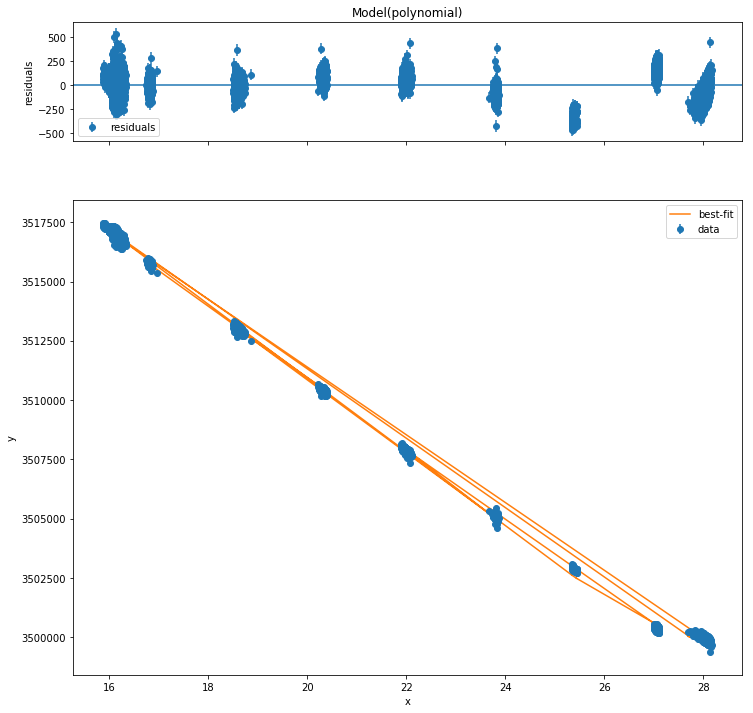

In [168]:
result.plot()

In [169]:
ns

array([35398.,  1270.,  4974.,  1439.,  1403.,  1430.,   204.,  1224.,
        2142.])

In [170]:
ns / ns.mean()

array([6.438081  , 0.23098375, 0.90465605, 0.26172096, 0.25517339,
       0.26008407, 0.0371029 , 0.22261741, 0.38958047])

In [ ]:
x_dat_avg = pd.Series(x_dat_avg)
ys = pd.Series(ys)
yerrs = pd.Series(yerrs)
ns = pd.Series(ns)

In [ ]:
result = polyfit_order_n(1,x_dat_avg, ys, ns.mean()*yerrs / ns)

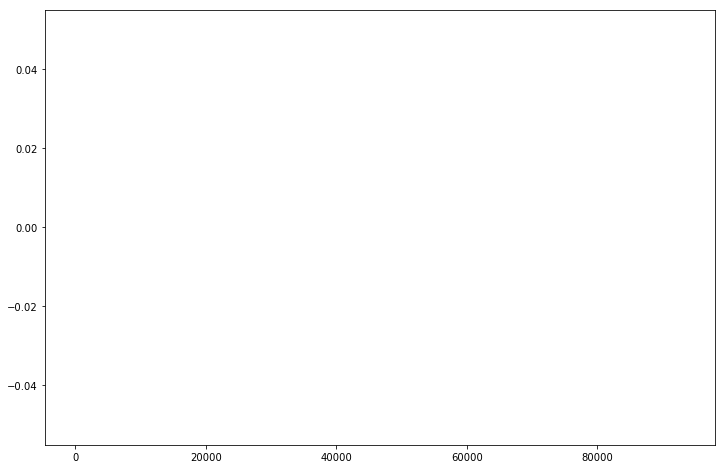

In [171]:
#def chi2(f, x, std):
#        return np.sum(np.square((x-f)/std))

#len(sigma_B)

#len(df_)

#fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
#fit_chi2
fit_chi2 = result.chisqr#0.3247

dof = len(df_) - 5#4 # 4 parameter fit
#dof

n = np.linspace(0,12, 100)

P = stats.chi2.pdf(n, dof)

# 3rd order
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
fig = scatter2d(df_.index, df_["DF0000000D5E803A_Cal_Res_Rel"], df_.days_delta, inline=False)

In [ ]:
result.plot()

In [172]:
def plot_polynomial(N, x_dat, y_dat, c_dat, result,
                    size=5, filename=None, inline=False, show_plot=True):
    
    ####averaged=True

    # plot the data
    fig = scatter2d(x_dat,
                    y_dat,
                    c_dat, opacity=0.9, show_plot=False)
    # add line for fit
    xs = np.linspace(x_dat.min(), x_dat.max(), 100)
    ys = result.eval(x=xs)
    fig.add_trace(go.Scatter(
                        x=xs, y=ys,
                        mode='lines', name=f'Order {N} Polynomial fit',#"|V|/|B| = A * Temp. + B",
                        line=dict(color='rgb(78, 42, 132)',#'deeppink',
                                  width=1,
                                  dash='dash')));
    #fig.add_trace(go.Scatter(
    #                    x=ts, y=B_lsq_avg,
    #                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
    #                    line=dict(color='purple', width=1,
    #                              dash='dash')));

    fig.update_traces(marker=dict(size=size));

    '''if averaged:
        fig.add_trace(go.Scatter(
            x= xs,
            y= ys,
            mode='markers',
            name='Averaged Data',
            error_x=dict(
                type='data',
                array=xerrs,
                width=1,
                thickness=1.,
                visible=True),
            error_y=dict(
                type='data',
                array=yerrs,
                width=1,
                thickness=1.,
                visible=True),
            marker=dict(
                size=3,
                color="Red",
            )
        ))'''

    #eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
    eqn = f"y = "
    for n in range(N+1):
        p = result.params[f"C_{n}"]
        eqn += f"{p:.2E} * x^{n}"
        if (n >= 2) and ((n+1)%3 == 0) and (n != N):
            eqn += "<br>    "
    ax = 250
    ay = -25
    if result.params["C_1"] < 0:
        i = 20
        #ax= +
        #ay= -
    else:
        i = -20
        ax = -ax
        ay = -ay
    fig.add_annotation(
        go.layout.Annotation(
                x=xs[i],
                y=ys[i],
                text=eqn,
                font=dict(
                    #family="Courier New, monospace",
                    size=12,
                    color="#ffffff"
                ),
                align="center",
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="#636363",
                ax=ax,
                ay=ax,
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
                opacity=0.65,
                showarrow=True#False
        )
    )

    fig.update_layout(title="y vs. x")
    fig.update_xaxes(title_text='x')
    fig.update_yaxes(title_text='y')
    #fig.update_layout( width=1000,height=600,)

    #filename = plotdir+"scaled_voltage_vs_temperature_3rd_order"
    if filename == None:
        if show_plot:
            if inline:
                iplot(fig)
            else:
                plot(fig)
    else:
        if show_plot:
            if inline:
                iplot(fig, filename=filename+'.html')
            else:
                plot(fig, filename=filename+'.html')
        pio.write_image(fig, filename+'.pdf')
        pio.write_image(fig, filename+'.png')
    
    return fig

In [173]:
fig = plot_poly_chi2(4, result)

NameError: name 'plot_poly_chi2' is not defined

In [ ]:
fig = plot_poly_chi2(1, result)

In [ ]:
N = 1
len(result.data) - (N+1) # y values

In [174]:
def plot_poly_chi2(N, result, filename=None, inline=False, show_plot=True):
    dof = len(result.data) - (N+1)
    fit_chi2 = result.chisqr
    P_at_fit = 1.-stats.chi2.cdf(fit_chi2, dof)
    print(f"Probability of Chi2: {P_at_fit}")
    
    lo = min(fit_chi2*0.5, dof / 4)
    hi = max(fit_chi2*1.5, 2*dof*1.5)
    
    n = np.linspace(lo,hi, 1000)

    P = stats.chi2.pdf(n, dof)
    
    n = pd.Series(n, name="Chi^2")
    P = pd.Series(P, name="p.d.f.")
    
    if np.isfinite(P.max()):
        ymax = P.max()
    else:
        ymax = 1.

    fig = scatter2d(n,P, show_plot=False)
    fig.add_trace(go.Scatter(
                            x=[fit_chi2, fit_chi2], y=[0., ymax],
                            mode='lines', name=f'Fit Chi^2 = {fit_chi2}',#"|V|/|B| = A * Temp. + B",
                            line=dict(color='rgb(78, 42, 132)',#'deeppink',
                                      width=1,
                                      dash='dash')));
        
    if filename == None:
        if show_plot:
            if inline:
                iplot(fig)
            else:
                plot(fig)
    else:
        if show_plot:
            if inline:
                iplot(fig, filename=filename+'.html')
            else:
                plot(fig, filename=filename+'.html')
        pio.write_image(fig, filename+'.pdf')
        pio.write_image(fig, filename+'.png')
    
    return fig

In [175]:
fig = plot_poly_chi2(4, result)

Probability of Chi2: 0.0


In [ ]:
len(result.data)

In [ ]:
len(result.params) - 2

In [ ]:
result.chisqr

In [ ]:
result.

In [ ]:
result.eval(x=df[f"{probe}_Cal_T"])

In [ ]:
polynomial(np.array([0,1,2]), len(result.params)-2, **result.params)

In [ ]:
    df_["Bmag_lsq"] = volt_3rd(x_dat, A_fit, B_fit, C_fit, D_fit)
    df_["Bmag_lsq_avg"] = volt_3rd(x_dat, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

    ts = np.linspace(x_dat.min(), x_dat.max(), 25)

    B_lsq = volt_3rd(ts, A_fit, B_fit, C_fit, D_fit)
    B_lsq_avg = volt_3rd(ts, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

    B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
    B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

    averaged=True

    fig = scatter2d(x_dat,
                    y_dat,
                    df_.days_delta, opacity=0.8, show_plot=False)

    fig.add_trace(go.Scatter(
                        x=ts, y=B_lsq,
                        mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                        line=dict(color='rgb(78, 42, 132)',#'deeppink',
                                  width=1,
                                  dash='dash')));
    #fig.add_trace(go.Scatter(
    #                    x=ts, y=B_lsq_avg,
    #                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
    #                    line=dict(color='purple', width=1,
    #                              dash='dash')));

    fig.update_traces(marker=dict(size=1));

    if averaged:
        fig.add_trace(go.Scatter(
            x= xs,
            y= ys,
            mode='markers',
            name='Averaged Data',
            error_x=dict(
                type='data',
                array=xerrs,
                width=1,
                thickness=1.,
                visible=True),
            error_y=dict(
                type='data',
                array=yerrs,
                width=1,
                thickness=1.,
                visible=True),
            marker=dict(
                size=3,
                color="Red",
            )
        ))

    #eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
    eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E} * x^2 + {C_fit:.2E} * x^3 + {D_fit:.2E}"

    i = 6
    fig.add_annotation(
        go.layout.Annotation(
                x=ts[i],
                y=B_lsq.iloc[i],
                text=eqn,
                font=dict(
                    #family="Courier New, monospace",
                    size=14,
                    color="#ffffff"
                ),
                align="center",
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="#636363",
                ax=+250,
                ay=-25,
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
                opacity=0.7,
                showarrow=True#False
        )
    )

    fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
    fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
    fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
    fig.update_layout( width=1000,height=600,)

    filename = plotdir+"scaled_voltage_vs_temperature_3rd_order"

    plot(fig, filename=filename+'.html')

    pio.write_image(fig, filename+".pdf")
    pio.write_image(fig, filename+".png")



    def chi2(f, x, std):
        return np.sum(np.square((x-f)/std))

    len(sigma_B)

    len(df_)

    fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
    fit_chi2

    dof = len(df_) - 3#4 # 4 parameter fit
    dof

    n = np.linspace(1000,20000, 1000)

    P = stats.chi2.pdf(n, dof)

    # 3rd order
    plt.plot(n,P)
    plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

    # 4th order
    plt.plot(n,P)
    plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

## OLD

In [ ]:
high_point = (df[f"{probe}_Cal_T"] > 20) & (df[f"{probe}_Cal_T"] < 21)
low_point = (df[f"{probe}_Cal_T"] > 16) & (df[f"{probe}_Cal_T"] < 17)
mid_point = (df[f"{probe}_Cal_T"] > 18) & (df[f"{probe}_Cal_T"] < 19)
h = high_point & stable_temp
l = low_point & stable_temp
m = mid_point & stable_temp

In [ ]:
plt.hist(df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"], bins=50);

In [ ]:
fig = scatter2d(df[h][f"{probe}_Cal_T"], df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"],
                df[h].days_delta, inline=False)

In [ ]:
hist2 = plt.hist2d(df[h][f"{probe}_Cal_T"], df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"], bins=35);

In [ ]:
hist2[1]

In [ ]:
36*36

In [ ]:
len(hist2[1])

In [ ]:
len(hist2[2])

In [ ]:
int(np.floor(hist2[0].argmax() / 36))

In [ ]:
int(round(((hist2[0].argmax() / 35) - int(np.floor(hist2[0].argmax() / 35))) * 35))

In [ ]:
1296-int(np.floor(hist2[0].argmax() / 36))*36

In [ ]:
hist2[0][int(np.floor(hist2[0].argmax() / 35)), int(round(((hist2[0].argmax() / 35) - int(np.floor(hist2[0].argmax() / 35))) * 35))]

In [ ]:
for x, y in np.argwhere(hist2[0] == hist2[0].max()):
    # center is between x and x+1
    print(np.average(hist2[1][x:x + 2]), np.average(hist2[2][y:y + 2]))

In [ ]:
(df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"]).describe()

In [ ]:
df[h][f"{probe}_Cal_T"].describe()

In [ ]:
fig = scatter2d(df[stable_temp].index, df[stable_temp]["Floor"], inline=False)

In [ ]:
fig = scatter2d(df.index, df["Floor"].diff(5).rolling(5).mean(), inline=False)

In [ ]:
df["Roof"].diff(4).plot()

In [ ]:
df["NMR [T]"].plot()
#df["Roof"].diff(1).plot();

In [ ]:
df_ = df[l|m|h]

In [ ]:
def volt(temp, A, B):
    return A * temp + B

In [ ]:
guess = np.array([-1300 / 3.5, 2e6]) # A, B

In [ ]:
x_dat = df_[f"{probe}_Cal_T"]
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
params, cov = optimization.curve_fit(volt, x_dat, df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"], guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# Bmag ### STABLE TEMP
params, cov

In [ ]:
np.sqrt(cov[0,0])

In [ ]:
cov[0,1] / (np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))

Parameters have strong correlation

In [ ]:
A_fit, B_fit = params

In [ ]:
df_["Bmag_lsq"] = volt(x_dat, A_fit, B_fit)

In [ ]:
p_low = [df[l][f"{probe}_Cal_T"].mean(), (df[l][f"{probe}_Raw_Bmag"]/df[l]["NMR [T]"]).mean()]
p_high = [df[h][f"{probe}_Cal_T"].mean(), (df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"]).mean()]
p_mid = [df[m][f"{probe}_Cal_T"].mean(), (df[m][f"{probe}_Raw_Bmag"]/df[m]["NMR [T]"]).mean()]

In [ ]:
std_low = [df[l][f"{probe}_Cal_T"].std(), (df[l][f"{probe}_Raw_Bmag"]/df[l]["NMR [T]"]).std()]
std_high = [df[h][f"{probe}_Cal_T"].std(), (df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"]).std()]
std_mid = [df[m][f"{probe}_Cal_T"].std(), (df[m][f"{probe}_Raw_Bmag"]/df[m]["NMR [T]"]).std()]

In [ ]:
std_low

In [ ]:
fig = scatter2d(df_[f"{probe}_Cal_T"],
                df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"],
                df_.days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df_[f"{probe}_Cal_T"], y=df_["Bmag_lsq"],
                    mode='lines', name="|V|/|B| = A * Temp. + B",
                    line=dict(color='deeppink', width=1,
                              dash='dash')));
#plot(fig)

fig.update_traces(marker=dict(size=1));
#plot(fig);

fig.add_trace(go.Scatter(
    x= [p_low[0],p_mid[0],p_high[0]],
    y=[p_low[1],p_mid[1],p_high[1]],
    mode='markers',
    name='averaged_data',
    error_x=dict(
        type='data',
        array=[std_low[0], std_mid[0], std_high[0]],
        width=1,
        thickness=1.,
        visible=True),
    error_y=dict(
        type='data',
        array=[std_low[1], std_mid[1], std_high[1]],
        width=1,
        thickness=1.,
        visible=True),
    marker=dict(
        size=4,
        color="Red",
    )
))

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1200,height=900,)

#fig = go.Figure(traces)
plot(fig, filename=plotdir+"temp_fit_2point_aggregate.html")

In [ ]:
pio.write_image(fig, plotdir+"temp_fit_2point_aggregate.pdf")
pio.write_image(fig, plotdir+"temp_fit_2point_aggregate.png")

In [ ]:
std_low

In [ ]:
std_mid

In [ ]:
std_high

In [ ]:
### pick std = 55
std_volt = 45.#55.

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_[f"{probe}_Raw_Bmag"]/df_["NMR [T]"], std_volt)
fit_chi2

In [ ]:
# check std
df_2 = df_[100:500]

In [ ]:
fig = scatter2d(df_2.index, df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"],
               inline=False)

In [ ]:
scaled_B = df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"]
scaled_B.name = "Scaled |V|/|B|"

In [ ]:
fig = histo(scaled_B, bins=25,
               inline=False)

In [ ]:
dof = len(df_) - 2
dof

In [ ]:
stats.chi2.pdf(6300, 6325)

In [ ]:
n = np.linspace(0, 7000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
n[P.argmax()]

## Magnet Behavior

In [ ]:
probes

In [ ]:
x_dat = df.index
y_dat = df[f"{probes[0]}_Raw_X"]

In [ ]:
fig = scatter2d(x_dat, y_dat, df.days_delta, inline=False)